Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Ken Chen"
COLLABORATORS = ""

---

# Problem description

In the last assignment, we created fully connected neural networks to
solve the task of classifying whether a ship is present in a satellite photo.

This assignment will address the same task, but using Convolutional Neural Network layers.


## Goal:

In this notebook, you will need to create a model in `TensorFlow/Keras` *using Convolutional layers*  to classify satellite photos. 

- The features are images: 3 dimensional collection of pixels
  - 2 spatial dimensions
  - 1 dimension with 3 features for different parts of the color spectrum: Red, Green, Blue
- The labels are either 1 (ship is present) or 0 (ship is not present)

Unlike the model we created in the previous assignment (using Dense/Fully Connected layers)
we will retain *all three color channels* of the data rather than converting it to one channel gray scale.

There are two notebook files in this assignment:
- The one you are viewing now: First and only notebook you need to work on. 
    - Train your models here
    - There are cells that will save your models to a file
- **`Model_test.ipynb`**:
    - PLEASE IGNORE    


## Learning objectives
- Learn how to construct Neural Networks in a Keras Sequential model that uses Convolutional layer types.
- Appreciate how layer choices impact number of weights

# Import modules

In [2]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

## Import tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.3.0
Version 2, minor 3


In [3]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# API for students

We have defined some utility routines in a file `helper.py`. There is a class named `Helper` in it.  

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

`helper = helper.Helper()`

- getData: Get a collection of labeled images, used as follows

  >`data, labels = helper.getData()`
- showData: Visualize labelled images, used as follows

  >`helper.showData(data, labels)`
- plot training results: Visualize training accuracy, loss and validation accuracy, loss

  >`helper.plotTrain(history, modelName)`, where history is the result of model training
- save model: save a model in `./models` directory

  >`helper.saveModel(model, modelName)`
- save history: save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`
 


In [4]:
# Load the helper module
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper

helper = helper.Helper()


# Get the data

The first step in our Recipe is Get the Data.

We have provided a utility method `getData` to simplify this for you

In [5]:
# Get the data
data, labels = helper.getData()
n_samples, width, height, channel = data.shape

print("Data shape: ", data.shape)
print("Labels shape: ", labels.shape)
print("Label values: ", np.unique(labels))



Data shape:  (4000, 80, 80, 3)
Labels shape:  (4000,)
Label values:  [0 1]


We will shuffle the examples before doing anything else.

This is usually a good idea
- Many datasets are naturally arranged in a *non-random* order, e.g., examples with the sample label grouped together
- You want to make sure that, when you split the examples into training and test examples, each split has a similar distribution of examples

In [6]:
# Shuffle the data
data, labels = sklearn.utils.shuffle(data, labels, random_state=42)

## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek


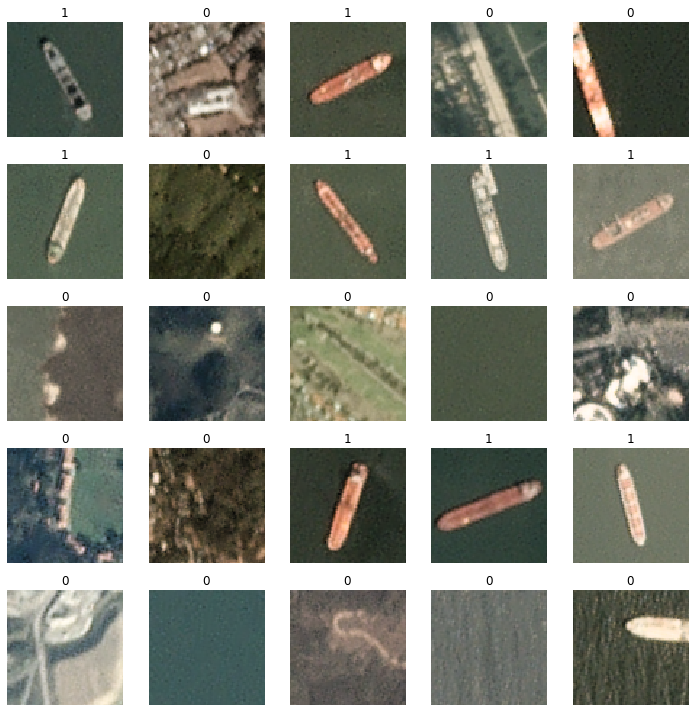

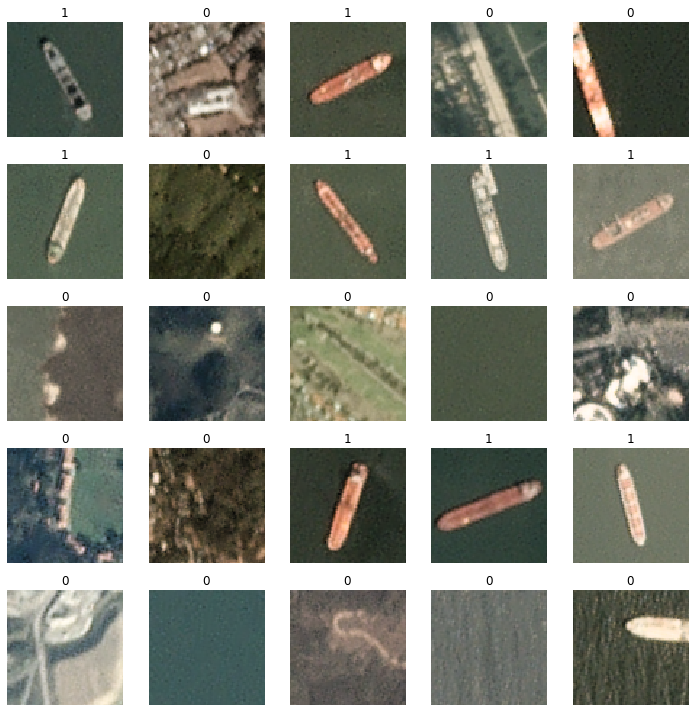

In [7]:
# Visualize the data samples
helper.showData(data[:25], labels[:25])


## Have  look at the data: Examine the image/label pairs

Rather than viewing the examples in random order, let's group them by label.

Perhaps we will learn something about the characteristics of images that contain ships.

We have loaded and shuffled our dataset, now we will take a look at image/label pairs. 

Feel free to explore the data using your own ideas and techniques.


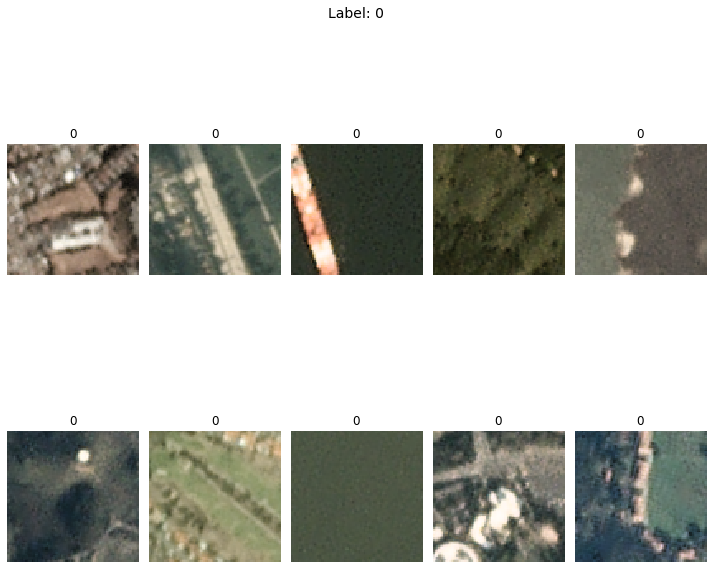

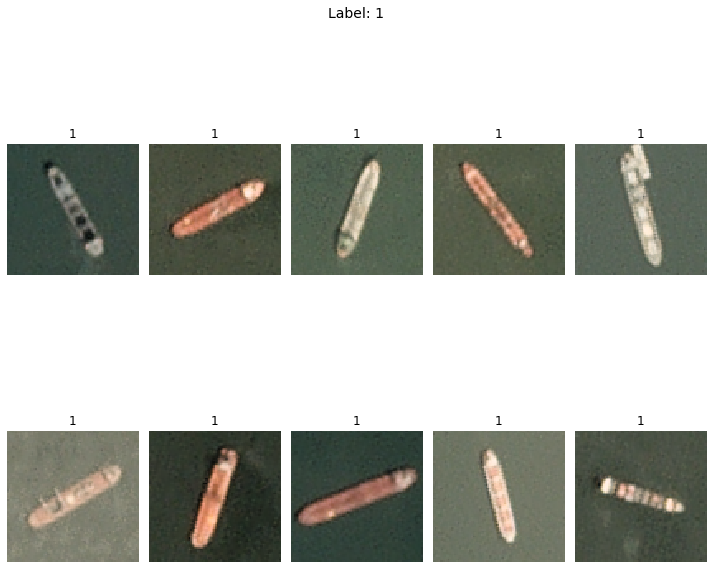

In [8]:
# Inspect some data (images)
num_each_label = 10

for lab in np.unique(labels):
    # Fetch images with different labels
    X_lab, y_lab = data[ labels == lab ], labels[ labels == lab]
    # Display images
    fig = helper.showData( X_lab[:num_each_label], [ str(label) for label in y_lab[:num_each_label] ], cmap="gray")
    _ = fig.suptitle("Label: "+  str(lab), fontsize=14)
    print("\n\n")


# Make sure the features are in the range [0,1]  

**Warm up exercise:** When we want to train on image data, the first thing we usually need to do is scaling. 

Since the feature values in our image data are between 0 and 255, to make them between 0 and 1, we need to divide them by 255.  

We also need to consider how to represent our target values
- If there are more than 2 possible target values, One Hot Encoding may be appropriate
    - **Hint**: Lookup `tf.keras.utils.to_categorical`
- If there are only 2 possible targets with values 0 and 1 we can use these targets without further encoding

**Question**
- Set variable `X` to be our gray-scale examples (`data_bw`), but with values in the range [0,1]
- Set variable `y` to be the representation of our target values



In [9]:
# Scale the data
# Assign values for X, y
#  X: the array of features
#  y: the array of labels
# The length of X and y should be identical and equal to the length of data.
from tensorflow.keras.utils import to_categorical
X, y = np.array([]), np.array([])

X = data/255

num_cases = np.unique(labels).shape[0]
if num_cases > 2:
    y = tf.keras.utils.to_categorical(labels)
else:
    y = labels
    
X = data/255

assert(X.max()<=1)
assert(X.min()>=0)

In [10]:
# Check if your solution is right 

assert X.shape == (4000, 80, 80, 3)
assert ( (y.shape == (4000,)) or (y.shape == (4000,1)) )


# Split data into training data and testing data
To train and evaluate a model, we need to split the original dataset into
a training subset (in-sample) and a test subset (out of sample).

We will do this for you in the cell below.

**DO NOT** shuffle the data until after we have performed the split into train/test sets
- We want everyone to have the **identical** test set for grading
- Do not change this cell



In [11]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Save X_train, X_test, y_train, y_test for final testing
if not os.path.exists('./data'):
    os.mkdir('./data')
np.savez_compressed('./data/train_test_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)


# Create a simple CNN model 

**Question:** Create a Keras Sequential model:
- With a single Convolutional Layer providing the number of features given in variable `num_conv_features1` indicated below.
    - You may choose your own kernel size
    - Use full padding
- Feeding a head layer implementing Classification  

Please name your Convolutional layer "CNN_1" and your Dense layer (head layer) "dense_head"

Set variable `model0` to be a Keras `Sequential` model object that implements your model.

**Hints:**
1. The `input shape` argument of the first layer should be the shape of a single example, which should be 3-dimensional. We don't need to flatten the data before feeding the Convolutional layer.
2. What is the shape of the output of the Convolutional Layer ? What should be the shape of the input to the Classification head ?
    - You may want to flatten the output of the Convolutional layer before feeding the Classification head.
3. The number of units in your head layer 
    - Depends on how you represented the target
    - It should be equal to the final dimension of  `y`

4. Activation function for the head layer: Since this is a classification problem
    - Use  `sigmoid` if your target's final dimension equals 1
    - Use  `softmax` if your target's final dimension is greater than 1

Think about the number of parameters in this model and whether
it is likely to be prone to overfitting. 
If you feel the need:

- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 
    - If you want to use a Dropout layer, you can use `Dropout()`, which is in  `tensorflow.keras.layers`. 



In [12]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers

# Set model0 equal to a Keras Sequential model
model0 = None

num_conv_features1 = 32

model0 = Sequential()
model0.add(layers.Conv2D(input_shape=X[0].shape, 
                         filters=num_conv_features1, 
                         kernel_size=(3,3), 
                         strides=(1,1), 
                         padding='same',
                         activation='relu',
                         name='CNN_1'))
model0.add(layers.Flatten(name='flatten_1'))
model0.add(layers.Dense(128, activation='relu', name="dense1"))
model0.add(layers.Dropout(0.2, name='dropout_1'))
model0.add(layers.Dense(1, activation='sigmoid', name="dense_head"))


model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               26214528  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 129       
Total params: 26,215,553
Trainable params: 26,215,553
Non-trainable params: 0
_________________________________________________________________


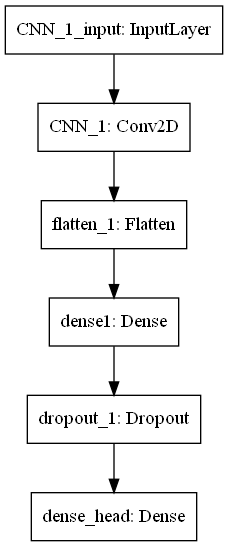

In [13]:
# Plot your model
plot_model(model0)

## Train model


**Question:**

Now that you have built your first model, you will compile and train it. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: 
    - `binary_crossentropy` if your target is one-dimensional
    - `categorical_crossentropy`if your target is One Hot Encoded
- Metric: "accuracy"
- Use the value in variable `max_epochs` as the number of epochs for training

- Plot your training results using the`plotTrain` method described in the Student API above.


Epoch 1/10
90/90 [==============================] - 19s 206ms/step - loss: 2.6663 - accuracy: 0.8146 - val_loss: 0.2726 - val_accuracy: 0.8875
Epoch 2/10
90/90 [==============================] - 19s 206ms/step - loss: 0.2592 - accuracy: 0.9153 - val_loss: 0.1533 - val_accuracy: 0.9361
Epoch 3/10
90/90 [==============================] - 19s 206ms/step - loss: 0.2070 - accuracy: 0.9358 - val_loss: 0.1802 - val_accuracy: 0.9236
Epoch 4/10
90/90 [==============================] - 19s 207ms/step - loss: 0.1384 - accuracy: 0.9538 - val_loss: 0.0935 - val_accuracy: 0.9597
Epoch 5/10
90/90 [==============================] - 19s 207ms/step - loss: 0.1204 - accuracy: 0.9597 - val_loss: 0.1010 - val_accuracy: 0.9597
Epoch 6/10
90/90 [==============================] - 19s 210ms/step - loss: 0.1027 - accuracy: 0.9663 - val_loss: 0.0780 - val_accuracy: 0.9681
Epoch 7/10
90/90 [==============================] - 19s 212ms/step - loss: 0.0779 - accuracy: 0.9743 - val_loss: 0.3767 - val_accuracy: 0.9083

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026A877D08C8>,
       dtype=object))

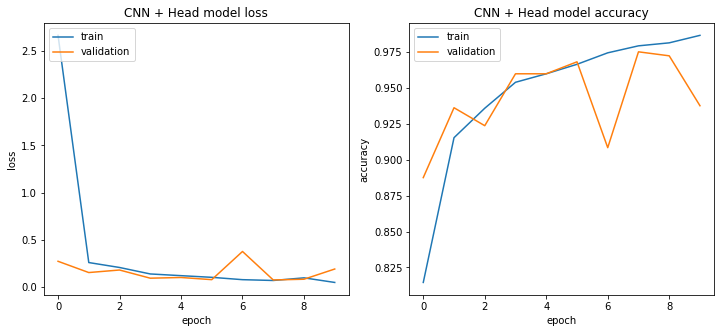

In [14]:
model_name0 = "CNN + Head"
max_epochs = 10

X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
model0.compile(loss='binary_crossentropy', metrics='accuracy')
history0 = model0.fit(X_train2, y_train2, epochs=max_epochs, validation_data=(X_valid, y_valid))

helper.plotTrain(history0, model_name0)

## How many weights in the model ?

**Question:** 

Calculate the number of parameters in your model.  

Set variable `num_parameters0` to be equal to the number of parameters in your model.

**Hint:** The model object may have a method to help you ! Remember that Jupyter can help you find the methods that an object implements.



In [15]:
# Set num_parameters2 equal to the number of weights in the model
num_parameters0 = None

num_parameters0 = model0.count_params()

print("Parameters number in model0: ", num_parameters0)

Parameters number in model0:  26215553


## Evaluate the model

**Question:**

We have trained our model. We now need to  evaluate the model using the test dataset created in an earlier cell.

Please store the model score in a variable named `score0`.   

**Hint:** The model object has a method  `evaluate`.  Use that to compute the score.




In [16]:
score0 = []

score0 = model0.evaluate(X_test, y_test, verbose=0)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name0, l=score0[0], a=score0[1]))

CNN + Head: Test loss: 0.26 / Test accuracy: 0.91


Your test accuracy should be around 0.9

## Save the trained model0 and history for submission

Your fitted model can be saved for later use
- In general: so you can resume training at a later time
- In particular: to allow us to grade it !

Execute the following cell to save your model, which you will submit to us for grading.

In [17]:
helper.saveModel(model0, model_name0)
helper.saveHistory(history0, model_name0)

Directory .\models\CNN + Head already exists, files will be over-written.
Model saved in directory .\models\CNN + Head; create an archive of this directory and submit with your assignment.
Directory .\models\CNN + Head already exists, files will be over-written.


In [18]:
## Restore the model (make sure that it works)
model_loaded = helper.loadModel(model_name0)
score_loaded = model_loaded.evaluate(X_test, y_test, verbose=0)

assert score_loaded[0] == score0[0] and score_loaded[1] == score0[1]

# Create a model with 4 Convolutional layers

**Question:** 

We will now create a model with more Convolutional layers.
- Use **4** Convolutional layers.
    - You may choose your own kernel size
    - Use full padding
    - ReLU activation functions for the Convolutional layers

    - Each of the first two Convolutional layers should have the number of features given in variable `num_conv_features1` indicated below
        - Please name thee layers "CNN_1" and "CNN_2"
    - Each of the last two Convolutional layers should have the number of features given in variable `num_conv_features2` indicated below
        - Please name thee layers "CNN_3" and "CNN_4"
- Insert a `MaxPooling` layer after every two Convolutional layers (e.g., after CNN_2 and CNN_4)
    - to reduce each spatial dimension by a factor of 2  

- Please name your head layer "dense_head". 

Set variable `model1` to be a Keras `Sequential` model object that implements your model.

**Hints:**
- Don't forget to flatten the output of the layer feeding the Classification head 
- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 


In [19]:
# Set model1 equal to a Keras Sequential model
model1 = None
num_conv_features1 = 32
num_conv_features2 = 64

model1 = Sequential()
model1.add(layers.Conv2D(input_shape=X[0].shape, 
                         filters=num_conv_features1, 
                         kernel_size=(3,3), 
                         strides=(1,1), 
                         padding='same',
                         activation='relu',
                         name='CNN_1'))
model1.add(layers.Conv2D(filters=num_conv_features1, 
                         kernel_size=(3,3), 
                         strides=(1,1), 
                         padding='same',
                         activation='relu',
                         name='CNN_2'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool_1'))
           
model1.add(layers.Conv2D(filters=num_conv_features2, 
                         kernel_size=(3,3), 
                         strides=(1,1), 
                         padding='same',
                         activation='relu',
                         name='CNN_3'))
model1.add(layers.Conv2D(filters=num_conv_features2, 
                         kernel_size=(3,3), 
                         strides=(1,1), 
                         padding='same',
                         activation='relu',
                         name='CNN_4'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool_2'))

model1.add(layers.Flatten(name='flatten_1'))
model1.add(layers.Dense(128, activation='relu', name="dense1"))
model1.add(layers.Dropout(0.2, name='dropout_1'))
model1.add(layers.Dense(1, activation='sigmoid', name="dense_head"))


model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        18496     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        36928     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)            

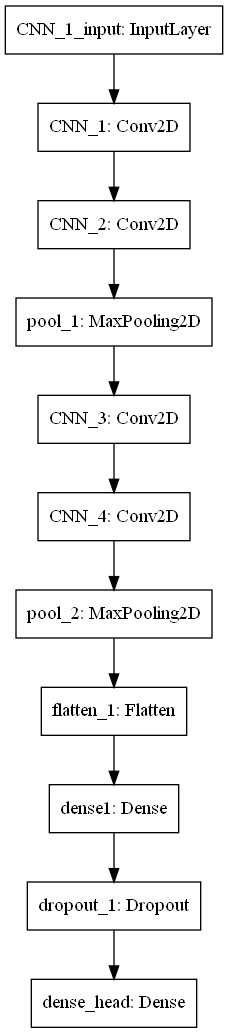

In [20]:
# Plot your model
plot_model(model1)

## Train model

**Question:**

Train your new model following the same instructions as given for training the first model.
- Use the same datasets for training and validation as in your first model
- Use the same Loss function and metrics as in your first model
- **Except**: Save your training results in a variable named `history1`



Epoch 1/10
90/90 [==============================] - 26s 288ms/step - loss: 0.4313 - accuracy: 0.8396 - val_loss: 0.2765 - val_accuracy: 0.8778
Epoch 2/10
90/90 [==============================] - 25s 282ms/step - loss: 0.2441 - accuracy: 0.9104 - val_loss: 0.1544 - val_accuracy: 0.9292
Epoch 3/10
90/90 [==============================] - 26s 288ms/step - loss: 0.1659 - accuracy: 0.9476 - val_loss: 0.0891 - val_accuracy: 0.9667
Epoch 4/10
90/90 [==============================] - 26s 286ms/step - loss: 0.0882 - accuracy: 0.9694 - val_loss: 0.0512 - val_accuracy: 0.9792
Epoch 5/10
90/90 [==============================] - 26s 287ms/step - loss: 0.0658 - accuracy: 0.9806 - val_loss: 0.0591 - val_accuracy: 0.9778
Epoch 6/10
90/90 [==============================] - 26s 286ms/step - loss: 0.1450 - accuracy: 0.9833 - val_loss: 0.0340 - val_accuracy: 0.9889
Epoch 7/10
90/90 [==============================] - 26s 286ms/step - loss: 0.0244 - accuracy: 0.9878 - val_loss: 0.0385 - val_accuracy: 0.9875

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026A880EC888>,
       dtype=object))

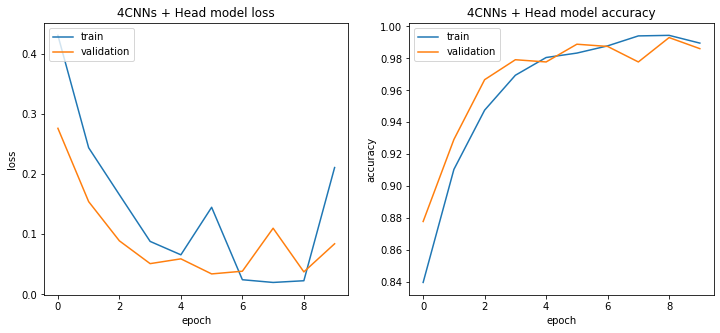

In [21]:
# Train the model using the API
model_name1 = "4CNNs + Head"
max_epochs = 10

X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
model1.compile(loss='binary_crossentropy', metrics='accuracy')
history1 = model1.fit(X_train2, y_train2, epochs=max_epochs, validation_data=(X_valid, y_valid))

helper.plotTrain(history1, model_name1)

## How many weights in this model ?

**Question:** Calculate the number of parameters in your new model.  

Set variable `num_parameters1` to be equal to the number of parameters in your model.



In [22]:
# Set num_parameters3 equal to the number of weights in the model
num_parameters1 = None

num_parameters1 = model1.count_params()

print('Parameters number in model1:', num_parameters1)

Parameters number in model1: 3342625


## Evaluate the model

Evaluate your new model following the same instructions as given for evaluating the first model.
- **Except**: store the model score in a variable named `score1`.  



In [23]:
score1 = []

score1 = model1.evaluate(X_test, y_test, verbose=0)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name1, l=score1[0], a=score1[1]))

4CNNs + Head: Test loss: 0.07 / Test accuracy: 0.98


Is your test accuracy higher than before ?

# Save your trained model1 and history1

In [24]:
helper.saveModel(model1, model_name1)
helper.saveHistory(history1, model_name1)

Directory .\models\4CNNs + Head already exists, files will be over-written.
Model saved in directory .\models\4CNNs + Head; create an archive of this directory and submit with your assignment.
Directory .\models\4CNNs + Head already exists, files will be over-written.


## Discussion


You can learn a lot by experimenting.  Some ideas to try:
- Change the kernel size in Convolutional layers
- Change the number of features of Convolutional layers
- Experiment with different pooling layers: `MaxPooling2D` and `AveragePooling2D`
- Change the activation function

Observe the effect of each change on the Loss and Accuracy.

Questions to consider:
- How did the number of parameters change between the two models ?
- How did the choice of layer types affect the number of parameters ?


# More experimenting

In [25]:
def test_model(model_test, model_name_test, callbacks=None): 
    
#     plot_model(model_test)

    X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
    model_test.compile(loss='binary_crossentropy', metrics='accuracy')

    history_test = model_test.fit(X_train2, y_train2, epochs=max_epochs, validation_data=(X_valid, y_valid), verbose=0, callbacks=callbacks)

    helper.plotTrain(history_test, model_name_test)
    score_test = model_test.evaluate(X_test, y_test, verbose=0)
    
    num_parameters = model_test.count_params()

    print("{n:s}: Test loss: {l:3.3f} / Test accuracy: {a:3.3f}".format(n=model_name_test, l=score_test[0], a=score_test[1]))
    print('Parameters number in model:', num_parameters)

## Change the kernel size

We find that the kernel size=4 makes best test accuracy 0.988 and test loss 0.056.

CNN with kernel size 2：: Test loss: 0.038 / Test accuracy: 0.983
Parameters number in model: 3306305
CNN with kernel size 3：: Test loss: 0.096 / Test accuracy: 0.975
Parameters number in model: 3342625
CNN with kernel size 4：: Test loss: 0.056 / Test accuracy: 0.988
Parameters number in model: 3393473
CNN with kernel size 5：: Test loss: 0.057 / Test accuracy: 0.985
Parameters number in model: 3458849


D:\programs\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\programs\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0, flags=flags)


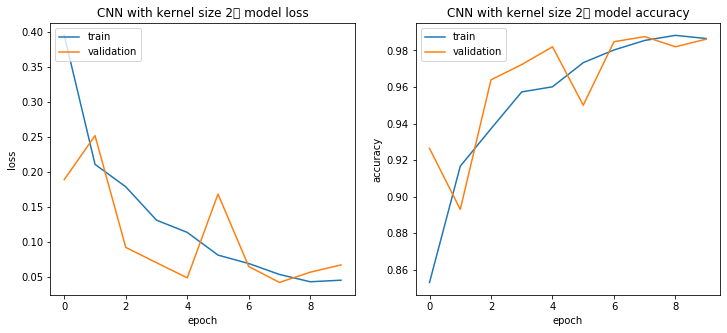

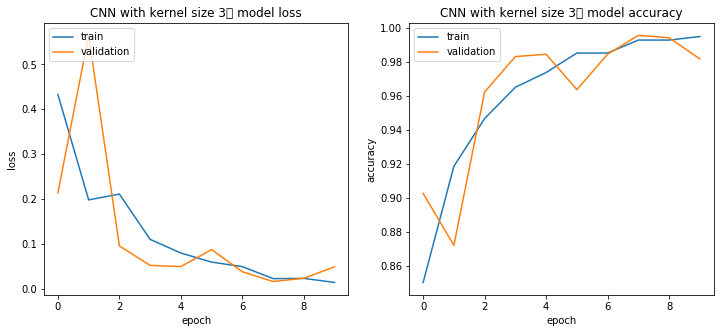

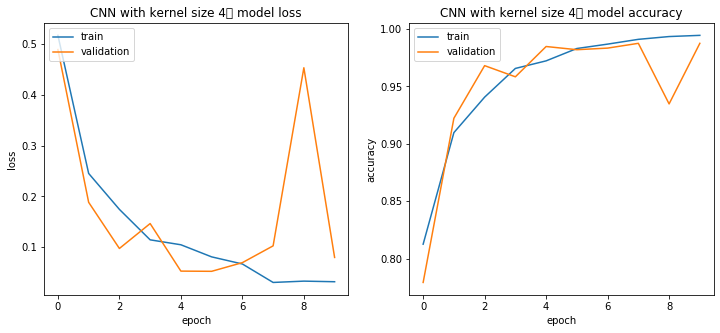

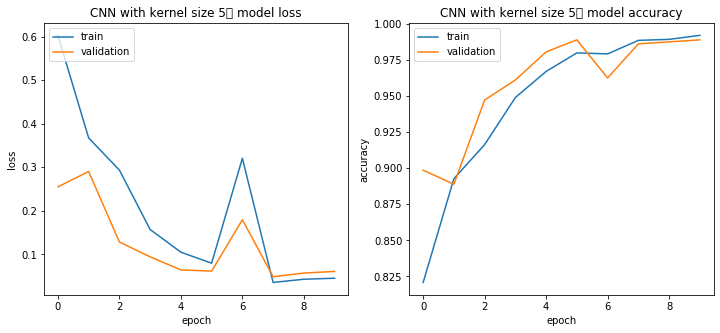

In [26]:
num_conv_features1 = 32
num_conv_features2 = 64
activation = 'relu'

for kernel_size in [2, 3, 4, 5]:
    model_kernel = Sequential()
    model_kernel.add(layers.Conv2D(input_shape=X[0].shape, 
                                   filters=num_conv_features1, 
                                   kernel_size=(kernel_size,kernel_size), 
                                   strides=(1,1), 
                                   padding='same',
                                   activation=activation,
                                   name='CNN_1'))
    model_kernel.add(layers.Conv2D(filters=num_conv_features1, 
                                   kernel_size=(kernel_size,kernel_size), 
                                   strides=(1,1), 
                                   padding='same',
                                   activation=activation,
                                   name='CNN_2'))
    model_kernel.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool_1'))

    model_kernel.add(layers.Conv2D(filters=num_conv_features2, 
                                   kernel_size=(kernel_size,kernel_size), 
                                   strides=(1,1), 
                                   padding='same',
                                   activation=activation,
                                   name='CNN_3'))
    model_kernel.add(layers.Conv2D(filters=num_conv_features2, 
                                   kernel_size=(kernel_size,kernel_size), 
                                   strides=(1,1), 
                                   padding='same',
                                   activation=activation,
                                   name='CNN_4'))
    model_kernel.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool_2'))

    model_kernel.add(layers.Flatten(name='flatten_1'))
    model_kernel.add(layers.Dense(128, activation='relu', name="dense1"))
    model_kernel.add(layers.Dropout(0.2, name='dropout_1'))
    model_kernel.add(layers.Dense(1, activation='sigmoid', name="dense_head"))


#     model_kernel.summary()
    model_test_name = 'CNN with kernel size {}：'.format(kernel_size)
    test_model(model_kernel, model_test_name)

## Change the number of features

We find that the features number (16,32) makes best test accuracy 0.990 but not the best loss 0.062.

CNN with num_features1=16, num_features2=32: Test loss: 0.062 / Test accuracy: 0.990
Parameters number in model: 1655313
CNN with num_features1=32, num_features2=64: Test loss: 0.050 / Test accuracy: 0.980
Parameters number in model: 3342625
CNN with num_features1=64, num_features2=128: Test loss: 0.114 / Test accuracy: 0.983
Parameters number in model: 6814017


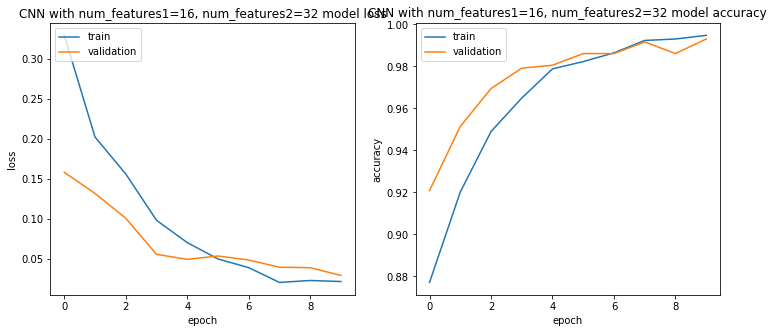

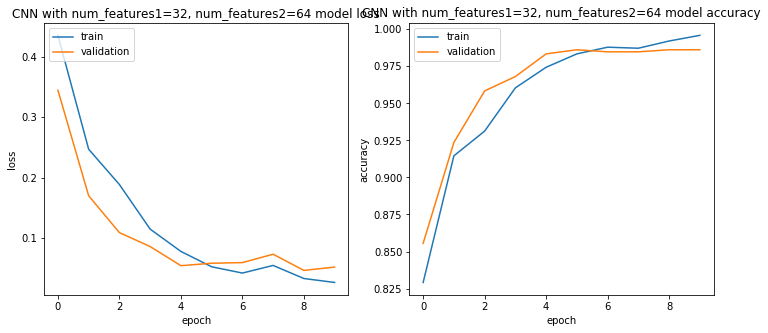

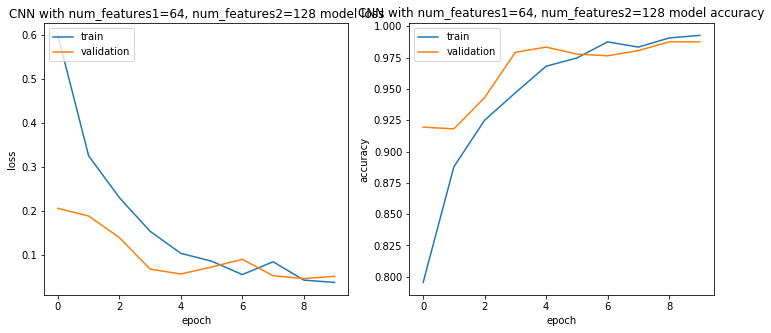

In [27]:
kernel_size = 3
activation = 'relu'

for num_conv_features1 in [16, 32, 64]:
    num_conv_features2 = num_conv_features1 * 2
    model_kernel = Sequential()
    model_kernel.add(layers.Conv2D(input_shape=X[0].shape, 
                                   filters=num_conv_features1, 
                                   kernel_size=(kernel_size,kernel_size), 
                                   strides=(1,1), 
                                   padding='same',
                                   activation=activation,
                                   name='CNN_1'))
    model_kernel.add(layers.Conv2D(filters=num_conv_features1, 
                                   kernel_size=(kernel_size,kernel_size), 
                                   strides=(1,1), 
                                   padding='same',
                                   activation=activation,
                                   name='CNN_2'))
    model_kernel.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool_1'))

    model_kernel.add(layers.Conv2D(filters=num_conv_features2, 
                                   kernel_size=(kernel_size,kernel_size), 
                                   strides=(1,1), 
                                   padding='same',
                                   activation=activation,
                                   name='CNN_3'))
    model_kernel.add(layers.Conv2D(filters=num_conv_features2, 
                                   kernel_size=(kernel_size,kernel_size), 
                                   strides=(1,1), 
                                   padding='same',
                                   activation=activation,
                                   name='CNN_4'))
    model_kernel.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool_2'))

    model_kernel.add(layers.Flatten(name='flatten_1'))
    model_kernel.add(layers.Dense(128, activation='relu', name="dense1"))
    model_kernel.add(layers.Dropout(0.2, name='dropout_1'))
    model_kernel.add(layers.Dense(1, activation='sigmoid', name="dense_head"))


#     model_kernel.summary()
    model_test_name = 'CNN with num_features1={}, num_features2={}'.format(num_conv_features1, num_conv_features2)
    test_model(model_kernel, model_test_name)

## Different pooling layers

Using AveragePooling rather than MaxPooling slightly increases the performance on test set. Test accuracy 0.985 and loss 0.088.

CNN with AveragePooling: Test loss: 0.088 / Test accuracy: 0.985
Parameters number in model: 3342625


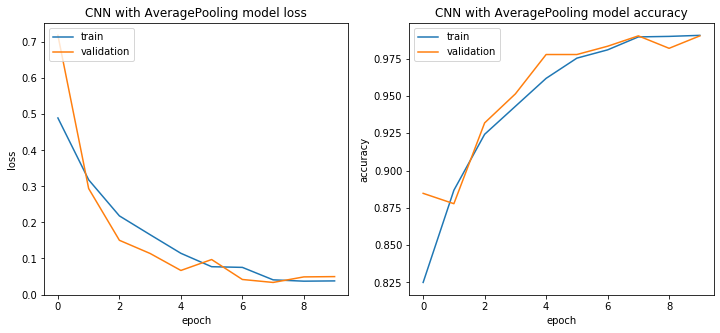

In [28]:
kernel_size = 3
num_conv_features1 = 32
num_conv_features2 = 64
activation = 'relu'

model_kernel = Sequential()
model_kernel.add(layers.Conv2D(input_shape=X[0].shape, 
                               filters=num_conv_features1, 
                               kernel_size=(kernel_size,kernel_size), 
                               strides=(1,1), 
                               padding='same',
                               activation=activation,
                               name='CNN_1'))
model_kernel.add(layers.Conv2D(filters=num_conv_features1, 
                               kernel_size=(kernel_size,kernel_size), 
                               strides=(1,1), 
                               padding='same',
                               activation=activation,
                               name='CNN_2'))
model_kernel.add(layers.AveragePooling2D(pool_size=(2, 2), name='pool_1'))

model_kernel.add(layers.Conv2D(filters=num_conv_features2, 
                               kernel_size=(kernel_size,kernel_size), 
                               strides=(1,1), 
                               padding='same',
                               activation=activation,
                               name='CNN_3'))
model_kernel.add(layers.Conv2D(filters=num_conv_features2, 
                               kernel_size=(kernel_size,kernel_size), 
                               strides=(1,1), 
                               padding='same',
                               activation=activation,
                               name='CNN_4'))
model_kernel.add(layers.AveragePooling2D(pool_size=(2, 2), name='pool_2'))

model_kernel.add(layers.Flatten(name='flatten_1'))
model_kernel.add(layers.Dense(128, activation='relu', name="dense1"))
model_kernel.add(layers.Dropout(0.2, name='dropout_1'))
model_kernel.add(layers.Dense(1, activation='sigmoid', name="dense_head"))


#     model_kernel.summary()
model_test_name = 'CNN with AveragePooling'
test_model(model_kernel, model_test_name)

## Change the activation function

Relu still makes the best performance compared with other activation functions such as tanh and selu with test accuracy 0.988 and test loss 0.057.

CNN with activation=relu: Test loss: 0.057 / Test accuracy: 0.988
Parameters number in model: 3342625
CNN with activation=tanh: Test loss: 0.076 / Test accuracy: 0.985
Parameters number in model: 3342625
CNN with activation=selu: Test loss: 0.145 / Test accuracy: 0.945
Parameters number in model: 3342625


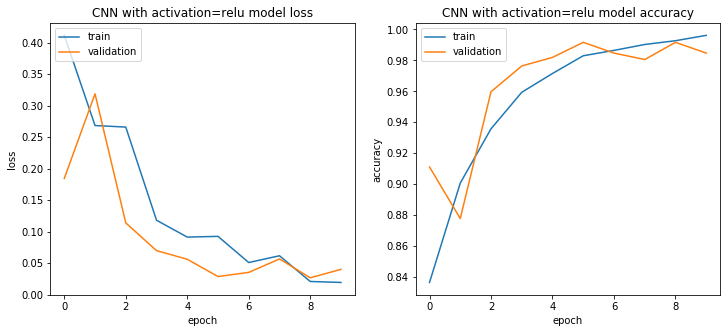

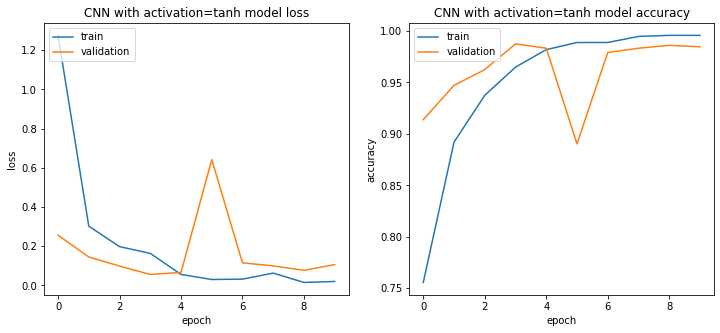

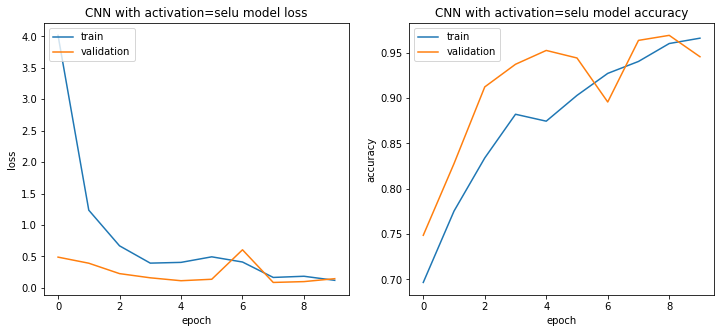

In [29]:
kernel_size = 3
num_conv_features1 = 32
num_conv_features2 = 64
activation = 'relu'

for activation in ['relu', 'tanh', 'selu']:
    
    model_kernel = Sequential()
    model_kernel.add(layers.Conv2D(input_shape=X[0].shape, 
                                   filters=num_conv_features1, 
                                   kernel_size=(kernel_size,kernel_size), 
                                   strides=(1,1), 
                                   padding='same',
                                   activation=activation,
                                   name='CNN_1'))
    model_kernel.add(layers.Conv2D(filters=num_conv_features1, 
                                   kernel_size=(kernel_size,kernel_size), 
                                   strides=(1,1), 
                                   padding='same',
                                   activation=activation,
                                   name='CNN_2'))
    model_kernel.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool_1'))

    model_kernel.add(layers.Conv2D(filters=num_conv_features2, 
                                   kernel_size=(kernel_size,kernel_size), 
                                   strides=(1,1), 
                                   padding='same',
                                   activation=activation,
                                   name='CNN_3'))
    model_kernel.add(layers.Conv2D(filters=num_conv_features2, 
                                   kernel_size=(kernel_size,kernel_size), 
                                   strides=(1,1), 
                                   padding='same',
                                   activation=activation,
                                   name='CNN_4'))
    model_kernel.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool_2'))

    model_kernel.add(layers.Flatten(name='flatten_1'))
    model_kernel.add(layers.Dense(128, activation='relu', name="dense1"))
    model_kernel.add(layers.Dropout(0.2, name='dropout_1'))
    model_kernel.add(layers.Dense(1, activation='sigmoid', name="dense_head"))


#     model_kernel.summary()
    model_test_name = 'CNN with activation={}'.format(activation)
    test_model(model_kernel, model_test_name)

## Questions to consider

**How did the number of parameters change between the two models ?**

Model0: Parameters number: 26215553, Test loss: 0.26 / Test accuracy: 0.91

Model1: Parameters number: 3342625, Test loss: 0.07 / Test accuracy: 0.98

Parameters number decreases by 87.5%, and the performance increases with model1 which also avoid over-fitting using dropout.

**How did the choice of layer types affect the number of parameters ?**

For model0, we directly flattern the convolution layer which produces parameters of 26214528 for the dense layer.

But for model1, we add pooling for every two convolution layers, which greatly decrease the number of parameters for dense layer to 3276928.

Deep networks have a much higher parameter efficiency than shallow ones: they can model complex functions using exponentially fewer neurons than shallow nets, allowing them to reach much better performance with the same amount of training data.